In [1]:
!pip install tensorflow==2.1.0

     |████████████████████████████████| 421.8MB 33kB/s 
     |████████████████████████████████| 450kB 37.5MB/s 
     |████████████████████████████████| 3.9MB 41.1MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=b0584bc3fd4d9dd4969f20c474532f6d6fe7134b385e3df20482a7d4f4481f49
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninsta

In [2]:
!pip install keras==2.3.1

     |████████████████████████████████| 378kB 2.9MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [3]:
!pip install plot_keras_history

  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.23-cp36-none-any.whl size=6405 sha256=8af68a21ad0a66cc2783fc031f8a6b44fe55d259ba8ff27295c290bf216bd777
  Stored in directory: /root/.cache/pip/wheels/c0/78/33/da5ed769fab5587fcdae95271e8d19106e3b92b3ae2d46382d
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.12-cp36-none-any.whl size=6596 sha256=1dd5cd98dad23135df090afe4ad37790f69c351b27502e8bde71ff6ab90c4e6a
  Stored in directory: /root/.cache/pip/wheels/cb/7a/44/401b091c00e8b2e314a474e3f7096d311239d95ff5315e25ab
  Created wheel for compress-json: filename=compress_json-1.0.4-cp36-none-any.whl size=4587 sha256=3f3a8e2a9a96063fcb3bd0a0a5b8b71f52691324f12fa90aa95c93841b92457a
  Stored in directory: /root/.cache/pip/wheels/83/ec/21/51460dd508e4a152c0643946c21fae84eb3391171164d35745
Successfully built plot-keras-history sanitize-ml-labels compress-json


In [6]:
# -*- coding: utf-8 -*-
"""Seq2Seq_LSTM.ipynb

pip install tensorflow==2.1.0
pip install keras==2.3.1

Created on Thu Aug 20 22:38:25 2020

@author: Dr Wang Aobo

"""

# Commented out IPython magic to ensure Python compatibility.
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
# %matplotlib inline
import re
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
from gensim.corpora.dictionary import Dictionary
from keras.preprocessing.text import Tokenizer, one_hot

from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model
from keras.utils import plot_model

import keras
print(keras.__version__)
import tensorflow as tf;
print(tf.__version__)


fullines= pd.read_table('/content/drive/My Drive/Text Processing Using Machine Learning/osha.txt', header=None,names = ["id","SeqB", "SeqA"])
fullines[0:10]
fullines.sample(frac=1, replace=True, random_state=1)

#make doc shorter in case too long time to train
maxlen_A=64
fullines.SeqA = fullines.SeqA.apply(lambda x: (' '.join(x.split(' ')[:maxlen_A-1])))

#Any pairwise and sequence data can be processed
#Not only for translation OR Everything is "translation"
#For example: 
  #Question , Answer pairs
  #Image , caption pairs
  #song , lyric pairs

#Data Preprocessing 
#Will differ according to the nature of the data. 
#This step is important!!! and time consuming!!!!

#Lowercase
fullines.SeqA=fullines.SeqA.apply(lambda x: x.lower())
fullines.SeqB=fullines.SeqB.apply(lambda x: x.lower())

#remove digits
remove_digits = str.maketrans('', '', digits)
fullines.SeqA=fullines.SeqA.apply(lambda x: x.translate(remove_digits))
fullines.SeqB=fullines.SeqB.apply(lambda x: x.translate(remove_digits))

#Special for Decoder SeqB
fullines.SeqB = fullines.SeqB.apply(lambda x : '$START '+ x + ' END$')

fullines.head()



lines, testlines =  train_test_split(fullines, train_size = 0.8,random_state=9)


#tokenize and index the sequence A

tokenizer_A = Tokenizer()
tokenizer_A.fit_on_texts(lines.SeqA)


seqA = tokenizer_A.texts_to_sequences(lines.SeqA)
print(seqA[0:10])
word_index_A = tokenizer_A.word_index

vocab_size_A = len(word_index_A) + 1  # Adding 1 because of reserved 0 index by Tokenizer
maxlen_A = max(len(x) for x in seqA) # longest text in train set
print('vocabubary size:',vocab_size_A)
print('max length text:',maxlen_A)


#tokenize and index the sequence B

tokenizer_B = Tokenizer(filters='!"#%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',)
tokenizer_B.fit_on_texts(lines.SeqB)

seqB = tokenizer_B.texts_to_sequences(lines.SeqB)
print(seqB[0:10])
word_index_B = tokenizer_B.word_index

print(word_index_B)

vocab_size_B = len(word_index_B) + 1  # Adding 1 because of reserved 0 index by Tokenizer
maxlen_B = max(len(x) for x in seqB) # longest text in train set
print('vocabubary size:',vocab_size_B)
print('max length text:',maxlen_B)

# seqA_vec -> encoder -> seqB_vec -> decoder -> seqB_one-hot-matrix (ahead by one timestep)

# First define the vectors' shape with all 0s as value
encoder_input_data = np.zeros((len(seqA), maxlen_A), dtype='float32')
decoder_input_data = np.zeros((len(seqB), maxlen_B), dtype='float32')
decoder_target_data = np.zeros((len(seqB), maxlen_B, vocab_size_B),dtype='float32')

#Then populate the word_index as the value
for i, (input_text, target_text) in enumerate(zip(seqA, seqB)):
    for t, word_id in enumerate(input_text):
        encoder_input_data[i, t] = word_id
    for t, word_id in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t] = word_id
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, word_id] = 1.0

#check the index for the first pair 
print("encoder:")
print(encoder_input_data[0])
print(decoder_input_data[0])
print("target:")
print(decoder_target_data[0,0])
print(decoder_target_data[0,1])
print(decoder_target_data[0,2])

#Build Seq2Seq model using LSTM

embedding_size = 8
hidden_dim = 8


#Encoder Part: {(encoder_input->embed_layer) -> lstm} -> encoder_states
encoder_inputs = Input(shape=(None,))#define encoder_input
en_x=  Embedding(vocab_size_A, embedding_size)(encoder_inputs)#link: encoder_input-->embed_layer

encoder = LSTM(hidden_dim, return_state=True)#define lstm 
encoder_outputs, state_h, state_c = encoder(en_x)#link: (encoder_input-->embed_layer)---->lstm

encoder_states = [state_h, state_c]#define the hidden/context status; reserved for decoder LSTM


# Decoder Part:{[(decoder_input->embed_layer) , encoder_states] ----> lstm} --> last_dense_layer
decoder_inputs = Input(shape=(None,))#define decoder_input

de_x=Embedding(vocab_size_B, embedding_size)(decoder_inputs)#link:(decoder_input->embed_layer)

decoder_lstm = LSTM(hidden_dim, return_sequences=True, return_state=True)#define lstm
decoder_outputs, _, _ = decoder_lstm(de_x,initial_state=encoder_states)#link: [(decoder_input->embed_layer),encoder_states] ----> lstm

decoder_dense = Dense(vocab_size_B, activation='softmax')#define last_dense_layer
decoder_outputs = decoder_dense(decoder_outputs)#link:{[(decoder_input->embed_layer),encoder_states] ----> lstm} -> last_dense_layer

#Link encoder -> decoder 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

model.summary()

#Train the model
hist = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=8,
          epochs=10,
          validation_split=0.2).history






2.3.1
2.1.0
[[5, 54, 4, 3, 37, 2, 1053, 1191, 7, 1330, 614, 12, 881, 1254, 207, 11, 288, 59, 1, 207, 9, 833, 22, 11, 2235, 1, 4360, 614, 1169, 33, 355, 597, 4, 3, 579, 78, 307, 6, 95, 509, 1, 136, 3, 2, 2757, 6, 5027, 233], [5, 48, 4, 12, 1054, 2614, 3, 20, 17, 2, 49, 23, 440, 864, 2615, 6, 3893, 4, 437, 2, 2065, 31, 7, 286, 1, 65, 763, 19, 4361, 6, 803, 10, 1, 165, 8, 1, 172, 4, 3, 574, 2, 864, 421, 15, 1, 1504, 8, 2], [4, 6, 2, 32, 49, 3214, 16, 37, 2, 6035, 764, 169, 556, 160, 7, 641, 1, 658, 1287, 19, 2, 624, 30, 196, 210, 4, 3, 42, 1, 3531, 6, 18, 2616, 3, 20, 1, 6036, 1, 110, 3, 30, 166, 6, 882, 642, 30, 33, 3, 87, 495], [5, 91, 4, 3, 20, 25, 2, 72, 226, 17, 2, 789, 183, 2, 810, 496, 3, 170, 438, 22, 4, 984, 39, 5, 1, 1836, 319, 29, 1, 470, 6, 765, 691, 1, 191, 11, 3, 307, 6, 11, 3, 95, 344, 7, 547, 7, 18, 643], [5, 54, 4, 2, 122, 88, 163, 15, 8011, 6, 3532, 44, 3, 342, 9, 2758, 50, 1222, 5, 1, 301, 84, 8, 1, 339, 390, 6, 3, 20, 19, 2, 1771, 96, 41, 5028, 4362, 2472, 191, 111, 23

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 6400 samples, validate on 1600 samples
Epoch 1/10
6400/6400 [==============================] - 74s 12ms/step - loss: 3.1573 - acc: 0.0600 - val_loss: 2.7397 - val_acc: 0.0667
Epoch 2/10
6400/6400 [==============================] - 72s 11ms/step - loss: 2.7344 - acc: 0.0918 - val_loss: 2.6482 - val_acc: 0.1058
Epoch 3/10
6400/6400 [==============================] - 73s 11ms/step - loss: 2.5957 - acc: 0.1175 - val_loss: 2.4984 - val_acc: 0.1329
Epoch 4/10
6400/6400 [==============================] - 72s 11ms/step - loss: 2.4599 - acc: 0.1398 - val_loss: 2.3915 - val_acc: 0.1450
Epoch 5/10
6400/6400 [==============================] - 73s 11ms/step - loss: 2.3694 - acc: 0.1476 - val_loss: 2.3288 - val_acc: 0.1531
Epoch 6/10
6400/6400 [==============================] - 73s 11ms/step - loss: 2.3217 - acc: 0.1564 - val_loss: 2.2979 - val_acc: 0.1556
Epoch 7/10
6400/6400 [==============================] - 73s 11ms/step - loss: 2.2901 - acc: 0.1605 - val_loss: 2.2724 - val_acc: 0.1615


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


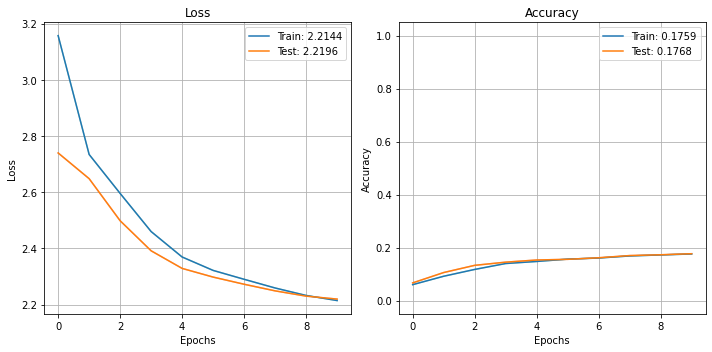

In [7]:
from plot_keras_history import plot_history
plot_history(hist)



In [10]:

#We are ready for inference. 
#(kopi o <pad> <pad> <pad>)	---------> ($START black coffee with sugar END$)
  ##Encoder(kopi o <pad> <pad> <pad>) = (h0,c0)
    ##(h0,c0)   +  $START ----decoder-----> (black,  (h1,c1)) 
    ##(h1,c1)	+  black -----decoder---->  (coffee, (h2,c2))
    ##(h2,c2)	+  coffee ----decoder-----> (with,   (h3,c3))
    ##(h3,c3)	+  with ------decoder--->   (sugar,  (h4,c4))
    ##(h4,c4)	+  sugar -----decoder---->  (END$,   (h5,c5))


#To decode a test sentence, we will repeatedly:
#1) Encode the input sentence and retrieve the initial state (encoder_states = [state_h, state_c])
        ##(kopi o)--->encoder_states = [state_h, state_c]
#2) Run one step of the decoder ([state_h, state_c] + START_ -----> black)
    #initial state(encoder_states = [state_h, state_c]) and a "START_" token as input. 
    #The output will be the next Target_Word (may or maynot be "black").
#3) Append the Target_Word with previous input ("START_ Target_Word")  and REPEAT (utill "_END" predicted).

#define encode_model seperatly as training stage 
#(kopi o)--->encoder_states = [state_h, state_c]
encoder_model = Model(encoder_inputs, encoder_states)
encoder_model.summary()

#define decoder_model seperatly as training stages
decoder_state_input_h = Input(shape=(hidden_dim,))
decoder_state_input_c = Input(shape=(hidden_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]


decoder_outputs, state_h, state_c = decoder_lstm(de_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
decoder_model.summary()

def decode_sequence(input_seq,num_decoder_tokens,encoder_model,decoder_model,vocab_B,max_decoder_seq_length):

    if len(input_seq)==0:
        return [vocab_B['end$']]
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of word_token.
    target_seq = np.zeros((1, 1))
    # Initialize with $start
    target_seq[0, 0] = vocab_B['$start']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1 (greedy decoding)).
    stop_condition = False
    decoded_word_index = []
    
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Predict a token
        predict_token_index = np.argmax(output_tokens[0, -1, :])
        decoded_word_index.append(predict_token_index)

        # Exit condition: either hit max length # or find stop character.
        if (predict_token_index == vocab_B['end$'] or
           len(decoded_word_index) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence to the predict word_token
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = predict_token_index

        # Update states
        states_value = [h, c]

    return decoded_word_index


print(seqA[0])

r = decode_sequence(seqA[0],vocab_size_B,encoder_model,decoder_model,word_index_B,maxlen_B)

print (r)

# Creating a reverse dictionary

reverse_word_map_A = dict(map(reversed, tokenizer_A.word_index.items()))
reverse_word_map_B = dict(map(reversed, tokenizer_B.word_index.items()))

# Function takes a tokenized sentence and returns the words
def indexSeq_to_text_A(list_of_indices):
    # Looking up words in dictionary
    words = [reverse_word_map_A.get(letter) for letter in list_of_indices]
    return(words)

def indexSeq_to_text_B(list_of_indices):
    # Looking up words in dictionary
    words = [reverse_word_map_B.get(letter) for letter in list_of_indices]
    return(words)

print(indexSeq_to_text_A(seqA[0]))
print(indexSeq_to_text_B(r))


    
def testSeq2Sq(listOfSeqA):
    
    listOfSeqB=[]
    token_seqA = tokenizer_A.texts_to_sequences(listOfSeqA)
    
    for a in token_seqA:
        r = decode_sequence(a,vocab_size_B,encoder_model,decoder_model,word_index_B,maxlen_B)
        tokens_b = indexSeq_to_text_B(r)
        sentB = ' '.join(tokens_b)
        listOfSeqB.append(sentB)
        
    return listOfSeqB

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 8)           112800    
_________________________________________________________________
lstm_1 (LSTM)                [(None, 8), (None, 8), (N 544       
Total params: 113,344
Trainable params: 113,344
Non-trainable params: 0
_________________________________________________________________
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None)         0                                            
_____________________________________________________________________

In [11]:

decode_testSeqB = testSeq2Sq(testlines.SeqA)
testlines['Translated'] = decode_testSeqB
print(testlines.head())

sample_train=lines[:10]
decode_sample_train = testSeq2Sq(sample_train.SeqA)
sample_train['Translated'] = decode_sample_train

print(sample_train.head())

             id  ... Translated
3644  200461440  ...    by end$
9184  201069853  ...    by end$
520   202527461  ...    by end$
5685  202612826  ...    by end$
2401  200926434  ...    by end$

[5 rows x 4 columns]
             id  ... Translated
9394  202252060  ...    by end$
50    201174380  ...    by end$
2884   14557516  ...    by end$
1183  201407780  ...    by end$
2077  200536068  ...    by end$

[5 rows x 4 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
print(testlines[:50].SeqB)

3644    $START  two workers died due to malfunctioning...
9184    $START  employee falls through framing into a ...
520     $START  employee is burned while spray paintin...
5685    $START  employee's finger tip is amputated by ...
2401    $START  employee is buried in trench  later di...
6510    $START  assistant elevator mechanic is killed ...
9853                  $START  electric shock & burn  END$
7185    $START  employee suffers heat exhaustion while...
7444    $START  employee's finger is amputated when ca...
49         $START  employee dies from heart disease  END$
8020    $START  employee falls from scaffold and is ki...
9622    $START  employee injures fingers while using d...
3111          $START  explosion kills two employees  END$
3520    $START  employee killed in  ft fall from sheet...
8626    $START  employee falls off horse  sustains con...
9701    $START  employee is injured when cart rolls ov...
1965    $START  employee is injured in forklift accide...
8723    $START

In [13]:
print(testlines[:50].Translated)

3644    by end$
9184    by end$
520     by end$
5685    by end$
2401    by end$
6510    by end$
9853    by end$
7185    by end$
7444    by end$
49      by end$
8020    by end$
9622    by end$
3111    by end$
3520    by end$
8626    by end$
9701    by end$
1965    by end$
8723    by end$
7776    by end$
3621    by end$
4279    by end$
3446    by end$
345     by end$
8409    by end$
8193    by end$
5939    by end$
9978    by end$
562     by end$
2374    by end$
1700    by end$
3106    by end$
2826    by end$
1383    by end$
1473    by end$
2241    by end$
3619    by end$
4572    by end$
6021    by end$
4951    by end$
6420    by end$
5222    by end$
6033    by end$
2464    by end$
9237    by end$
5517    by end$
4759    by end$
238     by end$
7961    by end$
5135    by end$
7364    by end$
Name: Translated, dtype: object
